In [1]:
from brownpy.gpu_sim import Universe
import brownpy.topology as Top
from brownpy.utils import prefix
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import numpy as np
from tqdm.auto import tqdm
plt.style.use('dark_background')

In [2]:
# Diffusion coefficient
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

# Geometry
R = 1E2 # A (10nm) - Pore radius
L = 500*R # A - Reservoir depht
factor = 0.10
Lm = R/factor # A - Reservoir height

# Timestep 
dt_marbach = 0.05*R**2/D
dt = int(10**np.floor(np.log10(dt_marbach)))
print(f'dt = {dt:.2e} fs = {prefix(dt*1E-15)}s')
N= 1024

dt = 1.00e+06 fs = 1 ns


In [3]:
top = Top.ElasticPore1(L=L, Lm=Lm, R=R)
u = Universe(N=N, top=top, D=D, dt=dt,
             output_path=f'pore_{factor:.2f}')
             

pore_0.hdf5 already exists, change output filename for pore_0_6.hdf5


(-1000.0, 1000.0)

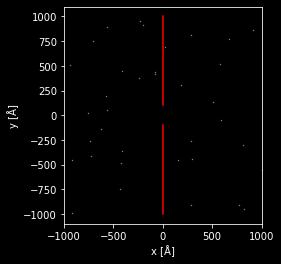

In [4]:
fig, ax = u.plot_pos()
ax.set_xlim(-Lm, Lm)

In [5]:
u.run(1_000_000, freq_dumps=100);
# u.run(1_000_000);

100%|██████████| 1000000/1000000 [00:03<00:00, 312944.78it/s, total=1 ms]

With 1024 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 5.5 fs
Engine: 203 ps
Transfert to RAM: 10.2 ps
Total: 213 ps
------------------------------------------
CPU time per step and per particles:
Other: 303 ps
Transfert to drive: 6.73 ps
Total: 310 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 310 ms


Reading region_0 ...
... Done
Reading trajectory ...
... Done


(-50000.0, 50000.0)

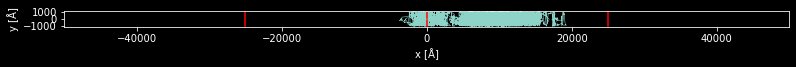

In [6]:
data=u[0]
trajectory = data['trajectory']
# Get particles that go inside the channel
# i_particle=1107
fig, ax1 = plt.subplots(figsize=(13,13))
# ax1_in = inset_axes(ax1, width="30%", height="30%", loc=1)

# ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:])
temp = np.argsort(np.sum(np.abs(trajectory[:,0,:-2])<1, axis=1))[::-1]
i_particle = temp[0]
# for ax in [ax1, ax1_in]:
for ax in [ax1]:  
        # ax.scatter(trajectory[i_particle,0,:], trajectory[i_particle,1,:], 
        #    c=np.arange(trajectory.shape[2]), marker='.', cmap='jet', s=2)
        for i_particle in temp[:1]:
                ax.plot(trajectory[i_particle,0,:], trajectory[i_particle,1,:], lw=0.5)

        # for i_particle in range(trajectory.shape[0]):
        #         ax.plot(trajectory[i_particle,0,:2], trajectory[i_particle,1,:2])

        top.plot(ax)

# ax1_in.set_xlim(-1000,1000)
# ax1_in.set_ylim(-1000,1000)
ax1.set_xlim(-L, L)

In [7]:
Nsteps = int(1.5*1E6*R**2/D/dt)
Nsteps

100000000

In [8]:
u.run(Nsteps);

100%|██████████| 100000000/100000000 [03:12<00:00, 519093.45it/s, total=101 ms]

With 1024 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 48.3 as
Engine: 1.84 ps
Transfert to RAM: 11.7 fs
Total: 1.85 ps
------------------------------------------
CPU time per step and per particles:
Other: 15.3 fs
Transfert to drive: 1.85 ps
Total: 1.86 ps
------------------------------------------
For a timestep of 1 ns
To simulate the trajectory of 1 particle during 1 s, we need 1.86 ms


Reading region_0 ...
... Done


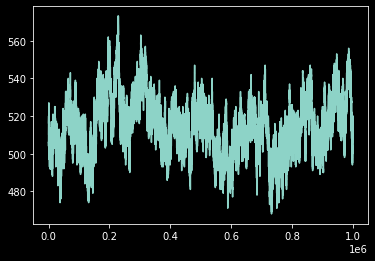

In [10]:
data=u[1]
region_0=data['region_0']
plt.plot(region_0[::100])

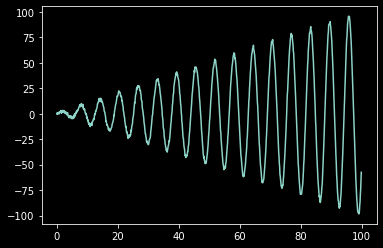

In [52]:
N = 1000
dt = 0.1
t = np.arange(0, N)*dt
signal = t*np.sin(t) + np.random.normal(size=1000)+0.5
plt.plot(t, signal)

In [53]:
def autocorrelation_loop(x):
    maxdelay = len(x)//5
    N = len(x)
    mean = np.average(x)
    var = np.var(x)
    xp = (x - mean)/np.sqrt(var)
    autocorrelation = np.zeros(maxdelay)
    for r in range(maxdelay):
        for k in range(N-r):
            autocorrelation[r] += xp[k]*xp[k+r]
        autocorrelation[r] /= float(N-r)
    return autocorrelation


def autocorrelation_np(x):
    xp = (x - np.mean(x))/np.std(x)
    result = np.correlate(xp, xp, mode='full')
    # return result
    return result[len(result)//2:]/len(xp)

In [54]:
ac_loop = autocorrelation_loop(signal)
ac_np = autocorrelation_np(signal)

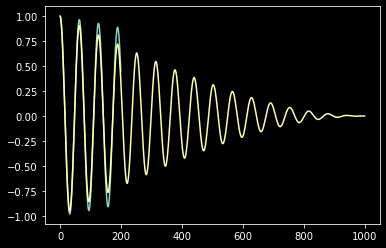

In [55]:
plt.plot(ac_loop)
plt.plot(ac_np)

In [93]:
def autocorrelation_fft(x):
    xp = np.fft.ifftshift((x - np.average(x))/np.std(x))
    n, = xp.shape
    xp = np.r_[xp[:n//2], np.zeros_like(xp), xp[n//2:]]
    f = np.fft.fft(xp)
    p = np.absolute(f)**2
    pi = np.fft.ifft(p)
    return np.real(pi)[:n//2]/(np.arange(n//2)[::-1]+n//2)

In [94]:
ac_fft = autocorrelation_fft(signal)
ac_fft2 = autocorrelation_fft2(signal)

In [106]:
from statsmodels.tsa.stattools import acf, acovf

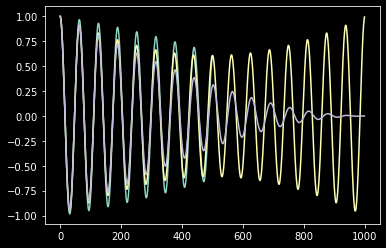

In [105]:
# plt.plot(ac_loop)
# plt.plot(ac_np)
plt.plot(ac_fft)
# plt.plot(ac_fft2)
ac_test = np.fft.irfft(np.absolute(np.fft.rfft((signal-np.average(signal))/np.std(signal)))**2)
ac_test/=ac_test.max()
plt.plot(ac_test)
# plt.plot(acf(signal,fft=False, nlags=1000))
plt.plot(acf(signal,fft=True, nlags=1000))

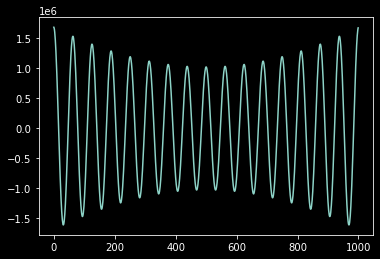

In [61]:
plt.plot(np.fft.irfft(np.absolute(np.fft.rfft(signal))**2))

In [17]:
import cupy as cp
def autocorrelation(x):
    xp = (x - np.mean(x))/np.std(x)
    result = np.correlate(xp, xp, mode='full')
    return result[result.size/2:]/len(xp)

In [18]:
ac = autocorrelation(region_0[::100])

TypeError: slice indices must be integers or None or have an __index__ method

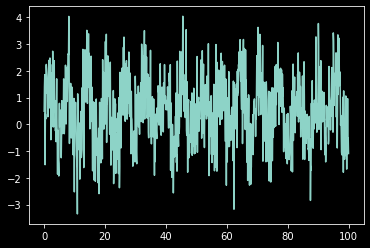

In [163]:
N = 1000
dt = 0.1
t = np.arange(0, N)*dt
signal = (np.sin(t) + np.random.normal(size=1000))+0.5
plt.plot(t, signal)

C:\Users\monet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)
C:\Users\monet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


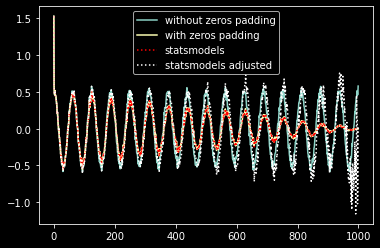

In [166]:
x=signal
n = len(x)
xo = x-np.mean(x)
Frf = np.fft.rfft(xo, n=n)
acov = np.fft.irfft(Frf * np.conjugate(Frf)) / n
acov = acov.real
plt.plot(acov, label = 'without zeros padding')

Frf = np.fft.rfft(xo, n=2*n+1)
acov = np.fft.irfft(Frf * np.conjugate(Frf))[:n] / n
acov = acov.real
plt.plot(acov, label = 'with zeros padding')

plt.plot(acovf(signal,adjusted=False), c='r', ls=':',
         label='statsmodels')

plt.plot(acovf(signal,adjusted=True), c='w', ls=':',
         label='statsmodels adjusted')
plt.legend()

C:\Users\monet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


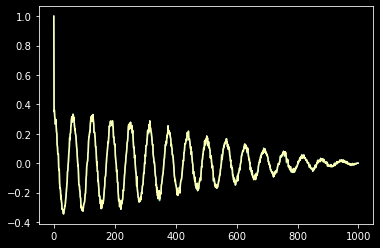

In [145]:
nlags=1000
ac = acov[: nlags + 1] / acov[0]
plt.plot(ac)
plt.plot(acf(signal,adjusted=False, nlags=nlags))

C:\Users\monet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:441: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


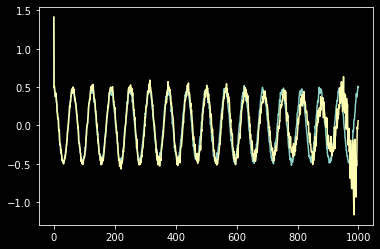

In [151]:
x=signal
n = len(x)
xo = x-np.mean(x)
Frf = np.fft.rfft(xo)
acov = np.fft.irfft(Frf * np.conjugate(Frf)) / n
plt.plot(acov)
plt.plot(acovf(signal,adjusted=True))

C:\Users\monet\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


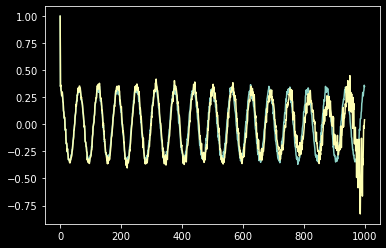

In [147]:
nlags=1000
ac = acov[: nlags + 1] / acov[0]
plt.plot(ac)
plt.plot(acf(signal,adjusted=True, nlags=nlags))

In [133]:
1

1

In [18]:
import cupy as cp
def PSD_gpu(x, dt):
    N = len(x)
    x_gpu = cp.asarray(x)
    psd = (cp.abs(cp.fft.rfft(x_gpu))**2).get()
    freqs = (cp.fft.rfftfreq(x.size, dt)).get()
    del x_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd/N, freqs

def PSD_gpu_binned(x, dt, bins):
    N = len(x)
    x_gpu = cp.asarray(x)
    psd_gpu = cp.abs(cp.fft.rfft(x_gpu))**2
    freqs_gpu = cp.fft.rfftfreq(x.size, dt)

    psd_binned_gpu, freqs_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], 
                                        weights=psd_gpu[1:], bins=bins)
    N_binned_gpu = cp.histogram(cp.log(freqs_gpu)[1:], bins=bins)[0]
    psd_averaged = (psd_binned_gpu/N_binned_gpu).get()
    freqs = ((freqs_binned_gpu[1:]+freqs_binned_gpu[:-1])/2.).get()
    
    del x_gpu, psd_gpu, freqs_gpu, psd_binned_gpu, freqs_binned_gpu, N_binned_gpu
    cp._default_memory_pool.free_all_blocks()
    return psd_averaged/N, np.exp(freqs)

<ipython-input-19-7c3c4f94db5c>:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(1/freqs/(R**2/D), psd)


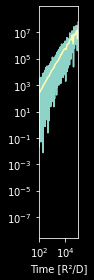

In [19]:
fig, ax = plt.subplots()
psd, freqs = PSD_gpu(region_0[::10], dt*10)
ax.loglog(1/freqs/(R**2/D), psd)
psd_bin, freqs_bin = PSD_gpu_binned(region_0[::10], dt*10, bins=100)
ax.loglog(1/freqs_bin/(R**2/D), psd_bin)
ax.set_xlabel('Time [R²/D]')
ax.set_xlim(1E2, 1E5)
ax.set_aspect('equal')
fig.tight_layout()

In [19]:
from scipy import signal

In [22]:
freqs_welch_elastic, psd_welch_elastic = signal.welch(region_0[::10], 0.1/dt , nperseg=1024)

In [23]:
1E15/(dt*len(region_0))

1000.0

<ipython-input-25-f8769d1687cb>:3: RuntimeWarning: divide by zero encountered in true_divide
  ax.loglog(1/freqs_welch_elastic/(R**2/D), psd_welch_elastic/10)


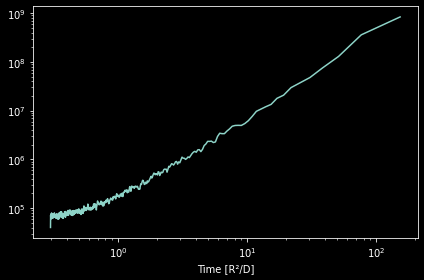

In [25]:
fig, ax = plt.subplots()

ax.loglog(1/freqs_welch_elastic/(R**2/D), psd_welch_elastic/10)
# ax.psd(region_0, 512, 1 / dt)
ax.set_xlabel('Time [R²/D]')
fig.tight_layout()